<a href="https://colab.research.google.com/github/m-hironori/PRML/blob/master/1_%E3%83%A2%E3%83%87%E3%83%AB%E4%BD%9C%E6%88%90%E3%81%AE%E5%9F%BA%E6%9C%AC(MNIST%E3%83%87%E3%83%BC%E3%82%BF%E3%81%A7%E6%89%8B%E6%9B%B8%E3%81%8D%E6%96%87%E5%AD%97%E8%AA%8D%E8%AD%98).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.5'

# モデル作成の基本(MNISTデータで手書き文字認識)

MNIST手書き文字認識を解いてみましょう。

## 問題設定
手書き数字画像(0-9)を入力に、何の数字かを当てる。

項目 | 内容
--- | ---
入力データ形式 | 手書きの数字(0-9)画像。28 * 28 の白黒。
予測すること | 0 - 9 のどれが書いてあるか。多クラス分類問題。 
評価指標 | accuracy
評価方法 | ホールドアウト(訓練 60,000, テスト10,000)
 

## データ準備

kerasにデータセットが用意されているので、これをロードする。

In [1]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


### データ量と内容を確認

In [12]:
import numpy as np

print(f"学習用データ {train_images.shape}, {train_images.dtype}")
print(f"学習用ラベル {train_labels.shape}, {train_labels.dtype}")
print(f"テストデータ {test_images.shape}, {test_images.dtype}")
print(f"テストラベル {test_labels.shape}, {test_labels.dtype}")

学習用データ (60000, 28, 28), uint8
学習用ラベル (60000,), uint8
テストデータ (10000, 28, 28), uint8
テストラベル (10000,), uint8


学習用データ60,000件、テスト用データ10,000件あることがわかる。
データ内容は整数型である。

次に、データとラベルの内容を見てみる。

In [3]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [16]:
print(f"学習データmax {np.max(train_images)}, min {np.min(train_images)}")
print(f"テストデータmax {np.max(test_images)}, min {np.min(test_images)} ")

学習データmax 255, min 0
テストデータmax 255, min 0 


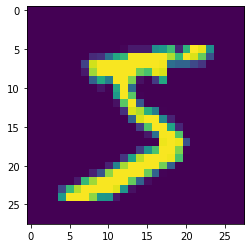

In [5]:
import matplotlib.pyplot as plt
plt.imshow(train_images[0])
plt.show()

In [7]:
train_labels[0]

5

In [19]:
print(f"学習ラベルmax {np.max(train_labels)}, min {np.min(train_labels)}")
print(f"学習ラベルuniq {np.unique(train_labels)}")
print(f"テストラベルmax {np.max(test_labels)}, min {np.min(test_labels)} ")
print(f"テストラベルuniq {np.unique(test_labels)}")

学習ラベルmax 9, min 0
学習ラベルuniq [0 1 2 3 4 5 6 7 8 9]
テストラベルmax 9, min 0 
テストラベルuniq [0 1 2 3 4 5 6 7 8 9]


データは、画像の1チャネルデータで 0 - 255 の値。
ラベルは、0 - 9 の数値で、学習用にもテスト用にも欠損しているラベルはない。

ラベルごとの頻度を見てみる。

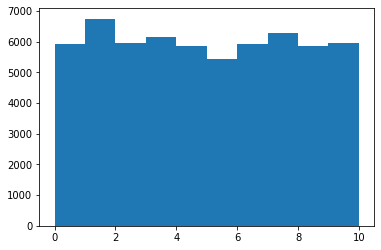

In [29]:
plt.hist(train_labels, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

(array([ 980., 1135., 1032., 1010.,  982.,  892.,  958., 1028.,  974.,
        1009.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

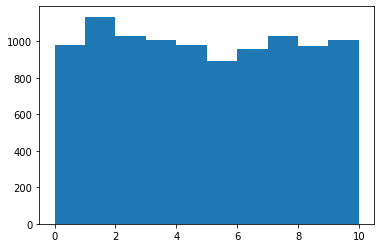

In [30]:
plt.hist(test_labels, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

"5"が少し少ない気もするが、大体均等であることがわかる。

ラベルに偏りはないので、accurayを指標にして大丈夫そうである。

## ベースライン指標
### 統計的検出力(statistical power)

0 - 9 を当てる問題であり、かつ、ラベル頻度も均等なので、
**accuracy 0.1**
が統計的検出力となる。

## モデル開発

まずは統計的検出力を上回る精度のモデルを作成する。

## 評価